<a href="https://colab.research.google.com/github/agusresasco/Deep_Learning_Course/blob/main/Copia_de_1_Lab01_Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from matplotlib import pyplot as plt
import os.path

In [3]:
if not os.path.isfile('lab_helper.py'):
    ! wget https://github.com/lab-ml-itba/Laboratorio-01/raw/master/lab_helper.py

--2022-08-16 10:20:47--  https://github.com/lab-ml-itba/Laboratorio-01/raw/master/lab_helper.py
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lab-ml-itba/Laboratorio-01/master/lab_helper.py [following]
--2022-08-16 10:20:47--  https://raw.githubusercontent.com/lab-ml-itba/Laboratorio-01/master/lab_helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10609 (10K) [text/plain]
Saving to: ‘lab_helper.py’

lab_helper.py       100%[===================>]  10.36K  --.-KB/s    in 0s      

2022-08-16 10:20:48 (82.0 MB/s) - ‘lab_helper.py’ saved [10609/10609]



In [4]:
from lab_helper import plot_boundaries, get_polynimial_set, plot_gaussians

ModuleNotFoundError: ignored

In [9]:
from sklearn.linear_model import LogisticRegression
import math
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
#from sklearn.linear_model.logistic import _logistic_loss
from scipy.stats import norm
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from scipy.stats import multivariate_normal

def plot_gaussians(X, mu1, sigma1, mu2, sigma2, prior1=0.5, prior2=0.5, N = 100, alpha = 0.5):
    X1 = np.linspace(X[:,0].min(), X[:,0].max(), N)
    X2 = np.linspace(X[:,1].min(), X[:,1].max(), N)
    X1, X2 = np.meshgrid(X1, X2)

    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(X1.shape + (2,))
    pos[:, :, 0] = X1
    pos[:, :, 1] = X2

    # The distribution on the variables X, Y packed into pos.
    Z_1 = multivariate_normal.pdf(pos, mu1, sigma1) * prior1
    Z_2 = multivariate_normal.pdf(pos, mu2, sigma2) * prior2
    fig = plt.figure(figsize=(15,10))
    ax = fig.gca(projection='3d')
    cm1 = plt.cm.Reds
    cm2 = plt.cm.Blues
    ax.contourf(X1, X2, Z_1, 256, cmap = cm1)
    ax.contourf(X1, X2, Z_2, 256, alpha = alpha, cmap = cm2)
    plt.show()

def get_weights_array(ws):
    weights_norm = []
    for weights in ws:
        weights_norm.append(np.linalg.norm(weights[0]))
    return weights_norm

def params_vs_pol_order(N, k = 2):
    k = 2
    return int(np.math.factorial(N+2)/(np.math.factorial(N+2-k)*np.math.factorial(k)))

def get_curves(alturas_pol, pesos, al_min, al_max, mean, std, order = 3, N=20, lamb = 1, ptos = 100):
    WMLs, WRRs = get_MLE_MAP_weights(alturas_pol, pesos, order = order, lamb = lamb, N = N)
    al = np.linspace(al_min, al_max,ptos)
    al_lin_pol = get_lin_reg_pol(al, order, normalize=False, mean=mean, std=std)
    curv_MLE = np.zeros([len(WMLs), ptos])
    curv_MAP = np.zeros([len(WRRs), ptos])
    for i, w in enumerate(WMLs):
        curv_MLE[i] = al_lin_pol.dot(w)
    for i, w in enumerate(WRRs):
        curv_MAP[i] = al_lin_pol.dot(w)
    return curv_MLE, curv_MAP

def plt_lin_reg_gauss(alturas, pesos, WML, sigma, Xmin, Xmax, Ymin, Ymax, order, mean, std, points = 100, ax=None):
    X = np.linspace(Xmin, Xmax, points)
    Y = np.linspace(Ymin, Ymax, points)
    X, Y = np.meshgrid(X, Y)
    Xr = X.reshape(-1)
    Yr = Y.reshape(-1)
    Y_est = get_lin_reg_pol(Xr, order, normalize=False, mean=mean, std=std).dot(WML)
    Z = norm.pdf(Yr - Y_est, 0, sigma).reshape(points, points)
    Z_points = norm.pdf(pesos - get_lin_reg_pol(alturas, order, normalize=False, mean=mean, std=std).dot(WML),0 , sigma)
    if ax is None:
        fig = plt.figure(figsize=(20,10))
        ax = fig.gca(projection='3d')
    ax.contour3D(X, Y, Z, 512)
    ax.scatter3D(alturas, pesos, Z_points, color='r', marker='o')
    ax.view_init(65,-120)
    plt.show()

def get_MLE_MAP_weights(alturas_pol, pesos, order = 3, lamb = 0.1, N = 20):
    # Devuelve dos arrays con los pesos de MAP y MLE
    ident = np.matrix(np.identity(order+1))
    WMLs = []
    WRRs = []
    for i in range(int(np.floor(len(pesos)/N))):
        X = np.matrix(alturas_pol[i*N:(i+1)*N])
        y = np.matrix(pesos[i*N:(i+1)*N]).T
        wML = ((X.T.dot(X))**-1*X.T)*y
        WMLs = WMLs + [wML.tolist()]
        wRR = (lamb*ident + X.T*X)**-1*X.T*y
        WRRs = WRRs + [wRR.tolist()]
        #print(i, len(y))
    WMLs = np.array(WMLs).reshape(-1,order+1)
    WRRs = np.array(WRRs).reshape(-1,order+1)
    return WMLs, WRRs

def get_ridge_weights(alturas, pesos, lamb = 0.1):
    ident = np.matrix(np.identity(alturas.shape[1]))
    X = np.matrix(alturas)
    y = np.matrix(pesos).T
    wRR = (lamb*ident + X.T*X)**-1*X.T*y
    return wRR

def get_lin_reg_pol(data, order=1, normalize=True, mean = 0, std = 1):
    data_rep = np.repeat(data.reshape(-1,1), order+1, axis=1)
    exps = [i for i in range(order+1)]
    data_all = np.power(data_rep, exps)
    if normalize:
        mean = data_all.mean(axis=0)[1:]
        std = data_all.std(axis=0)[1:]
        data_all[:, 1:] = data_all[:, 1:] - data_all.mean(axis=0)[1:]
        data_all[:, 1:] = data_all[:, 1:]/data_all.std(axis=0)[1:]
        return data_all, mean, std
    else:
        data_all[:, 1:] = data_all[:, 1:] - mean
        data_all[:, 1:] = data_all[:, 1:]/std
        return data_all

def nCr(n,r):
    f = math.factorial
    return int(f(n) / f(r) / f(n-r))

def get_polynimial_set(X, degree = 12, bias = True):
    # Recibe el dataset X de numero_de_muestras x features  y devuelve una matriz con todas las combinaciones 
    # De los productos del grado indicado en degree
    k = 2
    n = degree + k
    pos = 0
    X_mat = np.zeros((X.shape[0],nCr(n,k)))
    for i in range(degree + 1):
        for j in range(i+1):
            X_mat[:,pos] = (X[:,0]**(i-j))*X[:,1]**j
            pos = pos + 1
    if bias:
        return X_mat
    else:
        return X_mat[:,1:]

def plot_boundaries(X_train, y_train, score=None, probability_func=None, degree = None, n_colors = 100, mesh_res = 1000, ax = None):
    X = X_train #np.vstack((X_test, X_train))
    if len(y_train.shape) == 2 and y_train.shape[1] == 1:
        y_train = y_train.reshape(-1)
    margin_x = (X[:, 0].max() - X[:, 0].min())*0.05
    margin_y = (X[:, 1].max() - X[:, 1].min())*0.05
    x_min, x_max = X[:, 0].min() - margin_x, X[:, 0].max() + margin_x
    y_min, y_max = X[:, 1].min() - margin_y, X[:, 1].max() + margin_y
    hx = (x_max-x_min)/mesh_res
    hy = (y_max-y_min)/mesh_res
    x_domain = np.arange(x_min, x_max, hx)
    y_domain = np.arange(y_min, y_max, hy)
    xx, yy = np.meshgrid(x_domain, y_domain)

    if ax is None:
        ax = plt.subplot(1, 1, 1)
    
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if probability_func is not None:
        if degree is not None:
            polynomial_set = get_polynimial_set(np.c_[xx.ravel(), yy.ravel()], degree = degree)
            Z = probability_func(polynomial_set)[:, 1]
        else:
            Z_aux = probability_func(np.c_[xx.ravel(), yy.ravel()])
            Z = Z_aux[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
    
        cf = ax.contourf(xx, yy, Z, n_colors, vmin=0., vmax=1., cmap=cm, alpha=.8)
        plt.colorbar(cf, ax=ax)
        #plt.colorbar(Z,ax=ax)

        boundary_line = np.where(np.abs(Z-0.5)<0.001)

        ax.scatter(x_domain[boundary_line[1]], y_domain[boundary_line[0]], color='k', alpha=0.5, s=1)
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.text(xx.max() - .3, yy.min() + .3, score,
                size=20, horizontalalignment='right')

    # Plot also the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k', s=40, marker='o')
    

def fit_and_get_regions(X_train, y_train, X_test, y_test, degree = 2, lambd = 0, plot_it = True, print_it = False):
    X_train_degree = get_polynimial_set(X_train, degree=degree)
    X_test_degree = get_polynimial_set(X_test, degree=degree)
    # Defino el modelo de clasificación como Regresion Logistica
    if lambd == 0:
        C1 = 10000000000
    else:
        C1 = 1/lambd 
    #C2 = 1
    clf_logist_pol = LogisticRegression(C=C1, fit_intercept=False)

    # Entreno el modelo con el dataset de entrenamiento
    clf_logist_pol.fit(X_train_degree, y_train)

    # Calculo el score (Exactitud) con el dataset de testeo
    score_test_logist_pol = clf_logist_pol.score(X_test_degree, y_test)

    # Calculo tambien el score del dataset de entrenamiento para comparar
    score_train_logist_pol = clf_logist_pol.score(X_train_degree, y_train)
    
    #loss_train = _logistic_loss(clf_logist_pol.coef_, X_train_degree, y_train, 1 / clf_logist_pol.C)
    #loss_test = _logistic_loss(clf_logist_pol.coef_, X_test_degree, y_test, 1 / clf_logist_pol.C)

    # print('Test Accuracy (Exactitud):',score_test_logist_pol)
    # print('Train Accuracy (Exactitud):',score_train_logist_pol)
    # print('coeficientes:', clf_logist_pol.coef_)
    # print('intercept:', clf_logist_pol.intercept_)
    if plot_it:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
        plot_boundaries(X_train, y_train, score_train_logist_pol, clf_logist_pol.predict_proba, degree=degree, ax=ax1)
        plot_boundaries(X_test, y_test, score_test_logist_pol, clf_logist_pol.predict_proba, degree=degree, ax=ax2)
        print('Regresion Logistica Polinomial de orden '+str(degree) +', con lamdba (regularización L2):' +  str(lambd))
        plt.show()
    if print_it:
        print('Train Accuracy (Exactitud):',score_train_logist_pol)
        print('Test Accuracy (Exactitud):',score_test_logist_pol)
    return score_train_logist_pol, score_test_logist_pol, clf_logist_pol.coef_ #, loss_train, loss_test

def plot_boundaries_keras(X_train, y_train, score, probability_func, degree=None, bias=False, h = .02, ax = None, margin=0.5):
    X = X_train
    x_min, x_max = X[:, 0].min() - margin, X[:, 0].max() + margin
    y_min, y_max = X[:, 1].min() - margin, X[:, 1].max() + margin
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    if ax is None:
        ax = plt.subplot(1, 1, 1)
    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    
    if degree is not None:
        polynomial_set = get_polynimial_set(np.c_[xx.ravel(), yy.ravel()], degree = degree, bias=bias)
        Zaux = probability_func(polynomial_set)
    else:
        Zaux = probability_func(np.c_[xx.ravel(), yy.ravel()])
        # Z = Z_aux[:, 1]
    print(Zaux.shape)
    
    if Zaux.shape[1] == 2:
        Z = Zaux[:, 1]
    else:
        Z = Zaux[:, 0]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    cf = ax.contourf(xx, yy, Z, 50, cmap=cm, alpha=.8)
    plt.colorbar(cf, ax=ax)
    #plt.colorbar(Z,ax=ax)

    # Plot also the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k', s=100)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
            size=40, horizontalalignment='right')

# Generación de datos

In [5]:
def generate_elipse_data(N=500, random_state=42):
    np.random.seed(random_state)
    X = 2*(np.random.rand(N, 2)-0.5)
    y = 1*(2*(X[:,0]**2 + 2*X[:,1]**2 - 2*X[:,1]*X[:,0])<0.8)
    return X, y

def generate_gaussians_distributions(N=500, random_state=42):
    np.random.seed(random_state)
    X1 = np.random.multivariate_normal([0.5, 0.5], [[0.1,-0.085],[-0.085,0.1]], N//2) # primero la media y dps va la matriz de covarianza
    X2 = np.random.multivariate_normal([-0.25, -0.25], [[0.1,0],[0,0.1]], N//2) # esta distribucion es independiente porque tiene matriz diagonal la de arriba no
    X = np.append(X1, X2, axis=0)
    y = np.append(np.zeros(N//2), np.ones(N//2))
    return X, y

# Selección del Dataset

Dos tipos de datasets:
- generate_gaussians_distributions: Generado con dos gaussianas
- generate_elipse_data: Generado con distribución uniforme en el cuadrado [-1, 1], [-1, 1] y recortando con una elipse en el centro

Descomentar/comentar las lineas correspondientes para seleccionar uno u otro dataset

In [182]:
X, y = generate_gaussians_distributions()
X1, y1 = generate_elipse_data()

# Graficamos

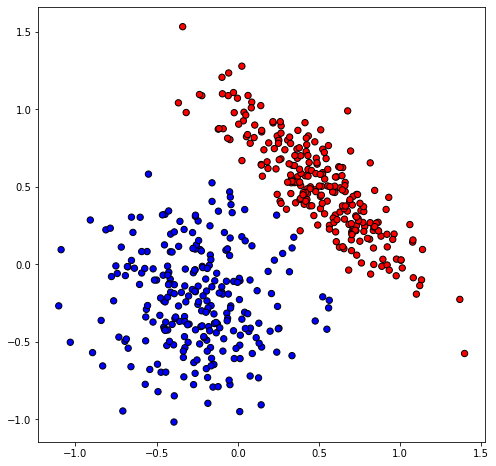

In [13]:
plt.figure(figsize=(8,8))
plot_boundaries(X,y)

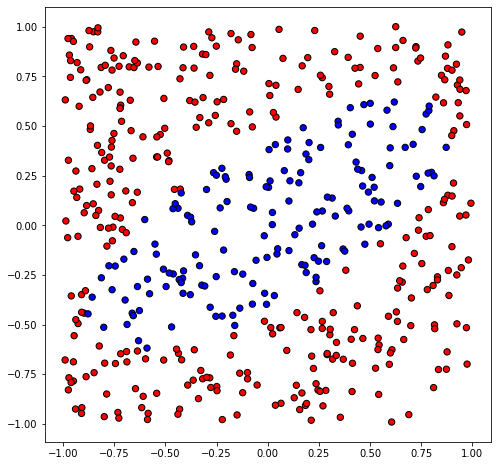

In [14]:
plt.figure(figsize=(8,8))
plot_boundaries(X1,y1)

# Inicialización del modelo

Para Naive Bayes probar con: 
- priors=None, var_smoothing=1e-09 (Ambos datasets)
- priors=None, var_smoothing=0.2 (para generate_elipse_data) var_smoothing=1 (para generate_gaussians_distributions) 
- priors=[0.5, 0.5] (para generate_elipse_data) priors=[0.7, 0.3] (para generate_gaussians_distributions), var_smoothing=1e-09 

Para QDA:
- priors=None, reg_param=0.0, store_covariance=True (Ambos modelos)
- Cambio los parámetros como quiera y verifique si ocurre lo esperado

In [133]:
model = GaussianNB(priors=[0.5, 0.5] , var_smoothing=1e-09)


In [134]:
# Entrenamiento del modelo
model.fit(X1,y1)

GaussianNB(priors=[0.5, 0.5])

In [135]:
if type(model)==GaussianNB:
    print(model.classes_) 
    prior1, prior2 = model.class_prior_
    sigma1, sigma2 = model.sigma_
    mu1, mu2 = model.theta_

[0 1]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `sigma_` was deprecated in 1.0 and will be removed in1.2. Use `var_` instead.
  warnings.warn(msg, category=FutureWarning)


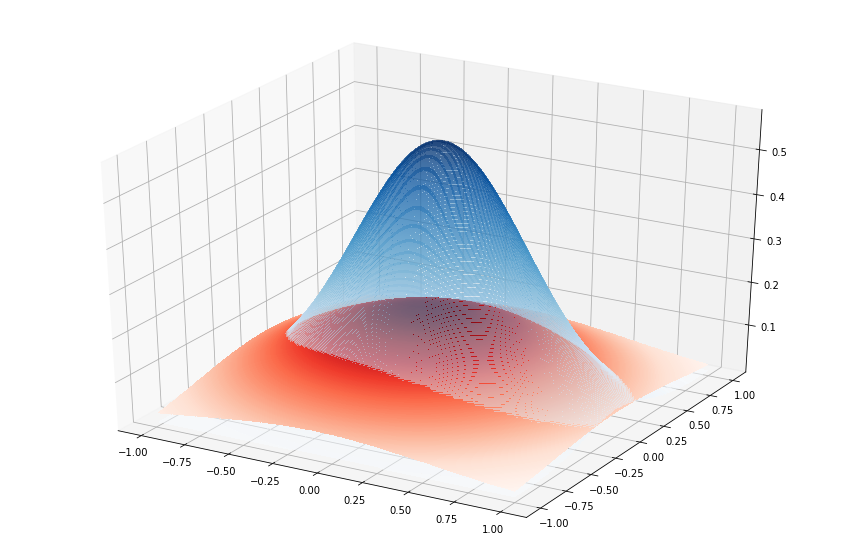

In [136]:
plot_gaussians(X1, mu1, sigma1, mu2, sigma2, prior1, prior2)

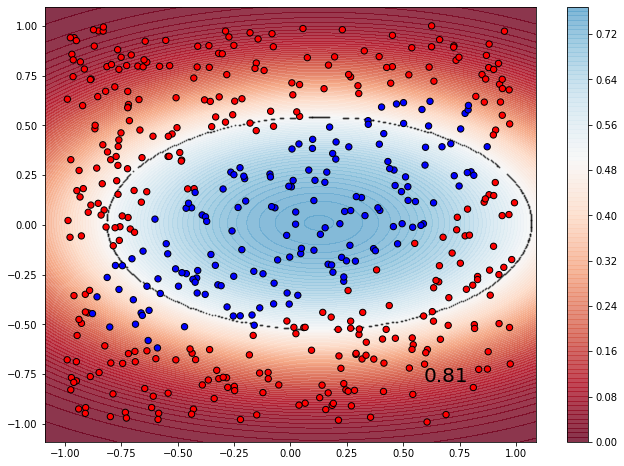

In [137]:
score = model.score(X1,y1)
plt.figure(figsize=(11,8))
plot_boundaries(X1,y1, score, probability_func=model.predict_proba, mesh_res=500)

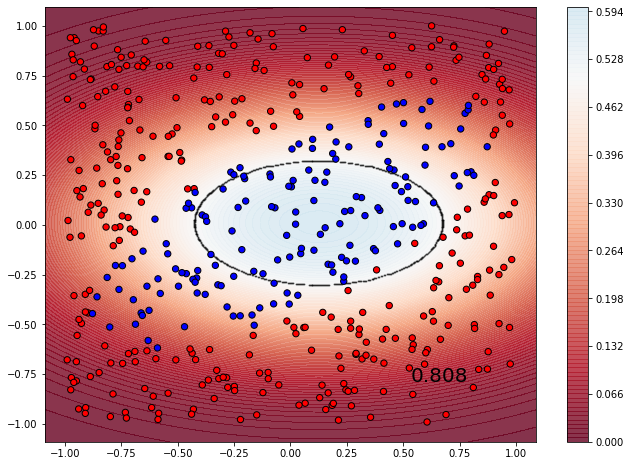

In [126]:
score = model.score(X1,y1)
plt.figure(figsize=(11,8))
plot_boundaries(X1,y1, score, probability_func=model.predict_proba, mesh_res=500)

In [132]:
# Proporcion de rojos vs azules
model.class_prior_

array([0.682, 0.318])

In [198]:
model.get_params()


{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

# QDA

In [121]:
model_qda = QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0, store_covariance=True)

In [122]:
# Entrenamiento del modelo
model_qda.fit(X1,y1)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [123]:
if type(model_qda)==QuadraticDiscriminantAnalysis:
    print(model_qda.classes_) 
    prior1_qda, prior2_qda =  model_qda.priors_
    mu1_qda, mu2_qda = model_qda.means_
    sigma1_qda, sigma2_qda = model_qda.covariance_

[0 1]


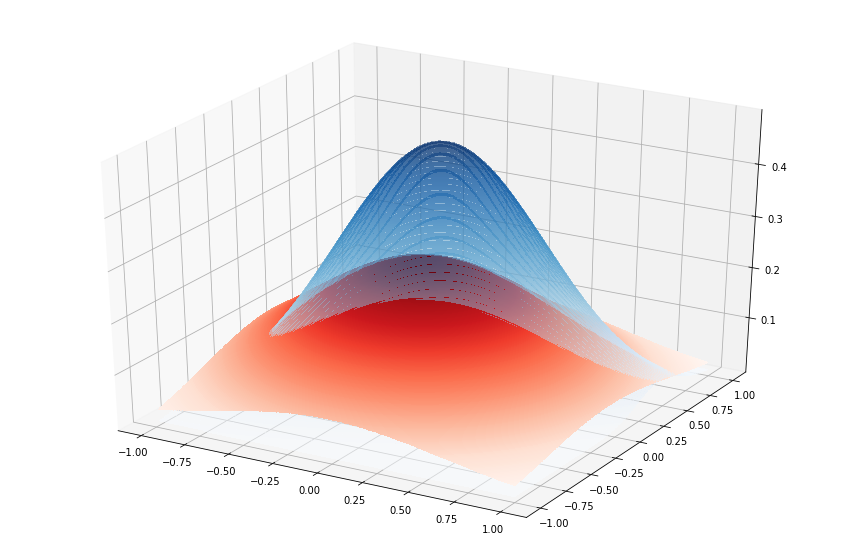

In [124]:
plot_gaussians(X1, mu1_qda, sigma1_qda, mu2_qda, sigma2_qda, prior1_qda, prior2_qda)

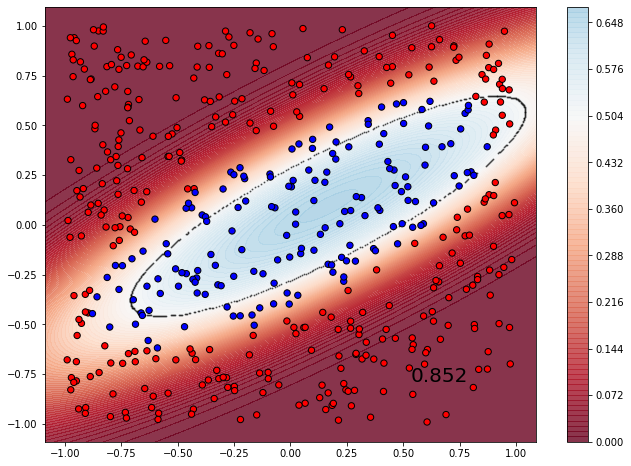

In [125]:
score = model_qda.score(X1,y1)
plt.figure(figsize=(11,8))
plot_boundaries(X1,y1, score, probability_func=model_qda.predict_proba, mesh_res=500)

# REGRESION LINEAR

In [183]:
model_lr = LogisticRegression(solver='lbfgs')

In [184]:
model_lr.fit(X1, y1)

LogisticRegression()

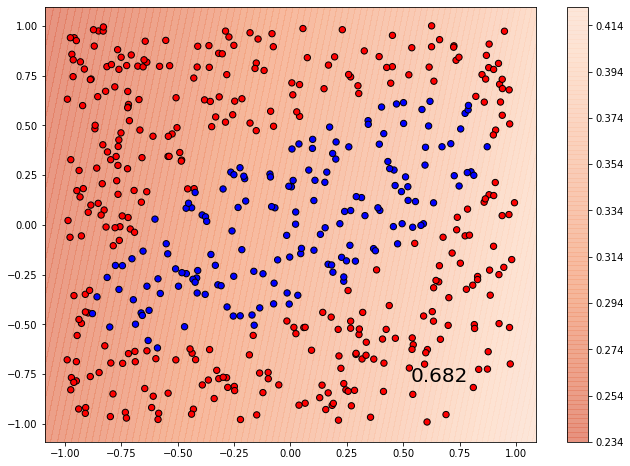

In [185]:
score = model_lr.score(X1,y1)
plt.figure(figsize=(11,8))
plot_boundaries(X1,y1, score, probability_func=model_lr.predict_proba, mesh_res=500)

In [186]:
model_lr.predict_proba(np.array([0.5, -0.75]).reshape(1, 2))

array([[0.63053289, 0.36946711]])

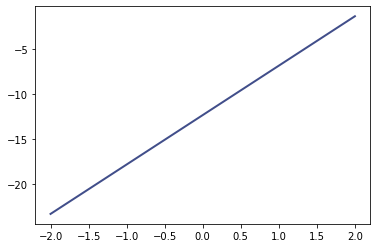

In [187]:
# Graficar la recta

x1 = np.linspace(-2, 2, 100)
x2 = -(model_lr.coef_[0][0] * x1 + model_lr.intercept_[0]) / model_lr.coef_[0][1]
plt.plot(x1, x2, color='#414e8a', linewidth=2)


In [191]:
print('Intercept: \n', model_lr.intercept_)

Intercept: 
 [-0.74692749]


In [195]:
print(x2)

[-23.27048169 -23.04864932 -22.82681695 -22.60498458 -22.3831522
 -22.16131983 -21.93948746 -21.71765509 -21.49582271 -21.27399034
 -21.05215797 -20.8303256  -20.60849322 -20.38666085 -20.16482848
 -19.94299611 -19.72116374 -19.49933136 -19.27749899 -19.05566662
 -18.83383425 -18.61200187 -18.3901695  -18.16833713 -17.94650476
 -17.72467238 -17.50284001 -17.28100764 -17.05917527 -16.83734289
 -16.61551052 -16.39367815 -16.17184578 -15.9500134  -15.72818103
 -15.50634866 -15.28451629 -15.06268391 -14.84085154 -14.61901917
 -14.3971868  -14.17535442 -13.95352205 -13.73168968 -13.50985731
 -13.28802493 -13.06619256 -12.84436019 -12.62252782 -12.40069544
 -12.17886307 -11.9570307  -11.73519833 -11.51336595 -11.29153358
 -11.06970121 -10.84786884 -10.62603646 -10.40420409 -10.18237172
  -9.96053935  -9.73870697  -9.5168746   -9.29504223  -9.07320986
  -8.85137748  -8.62954511  -8.40771274  -8.18588037  -7.96404799
  -7.74221562  -7.52038325  -7.29855088  -7.0767185   -6.85488613
  -6.633053

In [193]:
model_lr.coef_[0][1]

-0.06077631436802503

In [192]:
model_lr.coef_

array([[ 0.33368331, -0.06077631]])

In [158]:
from sklearn.metrics import log_loss


log_loss(y1,model_lr.predict_proba(X1))

0.6208125613102843

# REGRESION POLINOMIAL

In [162]:
print('La dimensión de las observaciones',X.shape, 'Tiene que quedar en (500, 6)')

La dimensión de las observaciones (500, 2) Tiene que quedar en (500, 6)


In [161]:
# EJERCICIO AGREGAR COLUMNAS

# Completar la función 
def add_columns(X):
    # Se agrega primer columna elevada al cuadrada como 3er columna
    X = np.append(X, (X[:,0]**2).reshape(-1,1), axis=1)
    # TODO: Agregar producto de primer columna por segunda columna en la cuarta columna
    X = np.append(X, (X[:,0]*X[:,1]).reshape(-1,1), axis=1) # Agregar aca no olvidar el reshape reshape(-1,1)
    # TODO: Agregar segunda columna elevada al cuadrada como 5er columna
    X = np.append(X, (X[:,1]**2).reshape(-1,1), axis=1) # Agregar aca no olvidar el reshape reshape(-1,1)
    # Se agrega la columna de 1s como 6ta columna para despues usar fit_intercept=False. Es necesario para la librería de graficación
    X = np.append(np.ones((len(X), 1)), X, axis=1)
    return X

In [166]:
X1 = add_columns(X1)

In [168]:
print('La dimensión de las observaciones',X1.shape, 'Tiene que quedar en (500, 6)')

La dimensión de las observaciones (500, 6) Tiene que quedar en (500, 6)


In [169]:
model_poly = LogisticRegression(solver='lbfgs', fit_intercept=False)

In [174]:
model_poly.fit(add_columns(X1), y)

LogisticRegression(fit_intercept=False)